# My Code

In [82]:
# !pip install umap-learn
# !pip install sentence-transformers
# !pip install gensim

In [1]:
import re
import numpy as np
import pandas as pd
from transformers import BertTokenizer, AutoModel
import torch
# import umap
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import scipy.sparse as sp
from sklearn.preprocessing import normalize
import gensim.corpora as corpora

2024-08-10 04:24:56.216828: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-10 04:24:56.242926: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-10 04:24:56.658001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('compile_keywords.csv', index_col=0)

In [27]:
df.head()

,video_title,comment_id,author,published_at,updated_at,like_count,text,text_clean,len_text_clean
0,"PDN Diretas, Pakar IT Tanggapi Hacker Beri Kun...",UgzRIV9osza-N_GbiQh4AaABAg,@erwinholid5874,2024-07-12T13:27:16Z,2024-07-12T13:27:16Z,0.0,"Jangan pernah percaya , kalau bisa harus ada c...",percaya copyan master data ganti system kunci ...,134
1,"PDN Diretas, Pakar IT Tanggapi Hacker Beri Kun...",UgzQkgAS-0mbF29wqT54AaABAg,@valentinussofa4135,2024-07-12T01:10:58Z,2024-07-12T01:10:58Z,0.0,"Setuju, SDM kita kritis soal Cybersecurity. Se...",setuju sdm kritis cybersecurity diawali kurang...,132
2,"PDN Diretas, Pakar IT Tanggapi Hacker Beri Kun...",UgwRhHirEjQuzKAtRlF4AaABAg,@franqlolofransisco4512,2024-07-11T23:13:44Z,2024-07-11T23:13:44Z,1.0,Hackher asal asalan tapi datanya bisa bocor.....,hackher asalan datanya bocor hacker benaran ha...,115
3,"PDN Diretas, Pakar IT Tanggapi Hacker Beri Kun...",UgzEYfwW_Cn9hd99a3l4AaABAg,@pick-upartist8268,2024-07-11T18:29:59Z,2024-07-11T18:29:59Z,1.0,"Prof... provokator😂, org cerdas emang suka nye...",prof provokator cerdas suka nyeleneh disayangk...,142
4,"PDN Diretas, Pakar IT Tanggapi Hacker Beri Kun...",UgwKE4_xBQV7eIO6zph4AaABAg,@afiffarhan1847,2024-07-11T17:24:43Z,2024-07-11T17:24:43Z,1.0,"Please lah up ini indo aduhh, negara lu lagi t...",please up indonesia aduh negara terancam merha...,90


In [28]:
len(df)

11577

In [6]:
df.describe()

,like_count,len_text_clean
count,11577.000000,11577.000000
mean,0.548933,100.899974
std,6.091849,135.765158
min,0.000000,1.000000
25%,0.000000,35.000000
50%,0.000000,65.000000
75%,0.000000,118.000000
max,465.000000,2735.000000


In [7]:
len(df[df["len_text_clean"]>250])/len(df)*100

6.8843396389392755

In [8]:
comments = list(df.text_clean)
df_documents = pd.DataFrame({"Document": comments,
                            "ID": range(len(comments)),
                            "Topic": None})

In [90]:
# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")

/home/abid/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [58]:
# Tokenize and get embeddings
def get_embeddings_bert(texts, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=250)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(batch_embeddings)
        
    embeddings = np.vstack(embeddings)
    return embeddings

In [106]:
# embeddings = get_embeddings(comments)

In [107]:
# Menyimpan embeddings ke file .npy
# np.save('embeddings_indobert-p1.npy', embeddings)

In [95]:
# Membaca embeddings dari file .npy
embeddings = np.load('embeddings_indobert-p1.npy')


In [96]:
# UMAP for Dimensionality Reduction
reducer = umap.UMAP(n_neighbors=15, n_components=50, metric='cosine', random_state=42)
umap_embeddings = reducer.fit_transform(embeddings)

/home/abid/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [104]:
np_umap = np.nan_to_num(umap_embeddings)

In [115]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit(np_umap)
df_documents['Topic'] = cluster_labels.labels_

/home/abid/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [153]:
# _update_topic_size
sizes = df_documents.groupby(['Topic']).count().sort_values("Document", ascending=False).reset_index()
topic_sizes = dict(zip(sizes.Topic, sizes.Document))

In [2]:
def _preprocess_text(documents):
    """ Basic preprocessing of text

    Steps:
        * Lower text
        * Replace \n and \t with whitespace
        * Only keep alpha-numerical characters
    """
    cleaned_documents = [doc.lower() for doc in documents]
    cleaned_documents = [doc.replace("\n", " ") for doc in cleaned_documents]
    cleaned_documents = [doc.replace("\t", " ") for doc in cleaned_documents]
    
    return cleaned_documents

In [3]:
vectorizer_model = CountVectorizer()

def TFIDF_IDFi(X_per_cluster, X_origin, all_documents):
    self_tfidf = TfidfTransformer()
    _global_tfidf =  self_tfidf.fit_transform(X_origin)
    global_df = pd.DataFrame(_global_tfidf.toarray())
    global_df['Topic'] = all_documents.Topic
    avg_global_df = global_df.groupby(['Topic'], as_index=False).mean()
    # avg_global_df
    avg_global_df = avg_global_df.drop(columns=['Topic'])
    _avg_global_tfidf = avg_global_df.values

    local_tfidf_transformer = TfidfTransformer()
    local_tfidf_transformer.fit_transform(X_per_cluster)
    _idfi = local_tfidf_transformer.idf_

    scores = _avg_global_tfidf * _idfi
    scores = normalize(scores, axis=1, norm='l1', copy=False)
    scores = sp.csr_matrix(scores)
    
    return scores

def _weighting_words(documents_per_topic, all_documents):
    concatenated_documents = _preprocess_text(documents_per_topic.Document.values)
    origin_documents = _preprocess_text(all_documents.Document.values)
    
    # count the words in a cluster
    vectorizer_model.fit(concatenated_documents)
    words = vectorizer_model.get_feature_names_out()
    
    # k * vocab
    X_per_cluster = vectorizer_model.transform(concatenated_documents)
    
    # D * vocab
    X_origin = vectorizer_model.transform(origin_documents)
    
    socres = TFIDF_IDFi(X_per_cluster, X_origin, all_documents)
    
    return socres, words
    

In [4]:
def _top_n_idx_sparse(matrix, n):
    """ Return indices of top n values in each row of a sparse matrix

    Retrieved from:
        https://stackoverflow.com/questions/49207275/finding-the-top-n-values-in-a-row-of-a-scipy-sparse-matrix

    Args:
        matrix: The sparse matrix from which to get the top n indices per row
        n: The number of highest values to extract from each row

    Returns:
        indices: The top n indices per row
    """
    indices = []
    for le, ri in zip(matrix.indptr[:-1], matrix.indptr[1:]):
        n_row_pick = min(n, ri - le)
        values = matrix.indices[le + np.argpartition(matrix.data[le:ri], -n_row_pick)[-n_row_pick:]]
        values = [values[index] if len(values) >= index + 1 else None for index in range(n)]
        indices.append(values)
    return np.array(indices)

In [33]:
def _top_n_values_sparse(matrix, indices):
    """ Return the top n values for each row in a sparse matrix

    Args:
        matrix: The sparse matrix from which to get the top n indices per row
        indices: The top n indices per row

    Returns:
        top_values: The top n scores per row
    """
    top_values = []
    for row, values in enumerate(indices):
        scores = np.array([matrix[row, value] if value is not None else 0 for value in values])
        top_values.append(scores)
    return np.array(top_values)

In [152]:
## Extract Topic
all_documents = df_documents
documents_per_topic = all_documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
concatenated_documents = _preprocess_text(documents_per_topic.Document.values)
origin_documents = _preprocess_text(all_documents.Document.values)
scores, words = _weighting_words(documents_per_topic, all_documents)


In [179]:
top_n_words=10

def _extract_words_per_topic(words, scores, top_n_words):

    labels = sorted(list(topic_sizes.keys()))

    indices = _top_n_idx_sparse(scores, 100)
    scores = _top_n_values_sparse(scores, indices)
    sorted_indices = np.argsort(scores, 1)
    indices = np.take_along_axis(indices, sorted_indices, axis=1)
    scores = np.take_along_axis(scores, sorted_indices, axis=1)

    topics = {label: [(words[word_index], score)
                        if word_index and score > 0
                        else ("", 0.00001)
                        for word_index, score in zip(indices[index][::-1], scores[index][::-1])
                        ]
                for index, label in enumerate(labels)}

    # topics = {label: values[:top_n_words] for label, values in topics.items()}
    topics = {label: values for label, values in topics.items()}

    return topics

In [153]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(topics):
    for label, words_scores in topics.items():
        word_freq = dict(words_scores)  # Convert list of tuples to dict
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        # plt.title(f'Topic: {label}')
        plt.show()

In [175]:
topics = _extract_words_per_topic(words, scores)
predictions = df_documents.Topic.to_list()

In [174]:
topics[0]

[('tua', 0.008412061086931365),
 ('bangka', 0.008338638197778976),
 ('mana', 0.00617244271148022),
 ('aja', 0.006058667513487243),
 ('kok', 0.006012122627661684),
 ('ya', 0.004963695080690512),
 ('teknologi', 0.004677188644194133),
 ('ngerti', 0.004663780361408458),
 ('ini', 0.0044208936281490046),
 ('nya', 0.004071765284726227)]

In [6]:
def _calculate_topic_diversity(topics):
        # topic_keywords = model.get_topics()
        topic_keywords = topics

        bertopic_topics = []
        for k,v in topic_keywords.items():
            temp = []
            for tup in v:
                temp.append(tup[0])
            bertopic_topics.append(temp)  

        unique_words = set()
        for topic in bertopic_topics:
            unique_words = unique_words.union(set(topic[:10]))
        td = len(unique_words) / (10 * len(bertopic_topics))

        return td

In [7]:
def get_topic(topics, topic_id):
        if topic_id in topics:
            return topics[topic_id]
        else:
            return False

In [8]:
def _calculate_cv_npmi(docs, topics, topics_model, vectorizer_model): 

    doc = pd.DataFrame({"Document": docs,
                    "ID": range(len(docs)),
                    "Topic": topics})
    documents_per_topic = doc.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = _preprocess_text(documents_per_topic.Document.values)

    vectorizer = vectorizer_model
    analyzer = vectorizer.build_analyzer()

    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in get_topic(topics_model, topic)] 
                for topic in range(len(set(topics))-1)]

    coherence_model = CoherenceModel(topics=topic_words, 
                                    texts=tokens, 
                                    corpus=corpus,
                                    dictionary=dictionary, 
                                    coherence='c_v')
    cv_coherence = coherence_model.get_coherence()

    coherence_model_npmi = CoherenceModel(topics=topic_words, 
                                    texts=tokens, 
                                    corpus=corpus,
                                    dictionary=dictionary, 
                                    coherence='c_npmi')
    npmi_coherence = coherence_model_npmi.get_coherence()

    return cv_coherence, npmi_coherence 

In [207]:
sentences = df_documents.Document.tolist()
td_score = _calculate_topic_diversity(topics)
cv_score, npmi_score = _calculate_cv_npmi(sentences, predictions, topics, vectorizer_model)

print(f'td_score: {td_score}')
print(f'cv_score: {cv_score}')
print(f'npmi_score: {npmi_score}')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

td_score: 0.54
cv_score: 0.4225208140541198
npmi_score: 0.0132243017490399


In [208]:
topics

{0: [('tua', 0.008412061086931365),
  ('bangka', 0.008338638197778976),
  ('mana', 0.00617244271148022),
  ('aja', 0.006058667513487243),
  ('kok', 0.006012122627661684),
  ('ya', 0.004963695080690512),
  ('teknologi', 0.004677188644194133),
  ('ngerti', 0.004663780361408458),
  ('ini', 0.0044208936281490046),
  ('nya', 0.004071765284726227)],
 1: [('aja', 0.0068772631025740645),
  ('gak', 0.00575059336274544),
  ('di', 0.005591478734458436),
  ('yg', 0.005381671214240959),
  ('ga', 0.004767894282023084),
  ('mundur', 0.004749907667842275),
  ('malu', 0.004431244736899665),
  ('kerja', 0.004085576123727081),
  ('nya', 0.003990062823035635),
  ('bisa', 0.00390376205075569)],
 2: [('di', 0.008168924089731645),
  ('data', 0.007252377083977621),
  ('bisa', 0.0053842825288556),
  ('nya', 0.004664380861934909),
  ('ada', 0.004610804970874641),
  ('windows', 0.004444060270755742),
  ('gak', 0.004287413343714617),
  ('aja', 0.004251082018070365),
  ('hacker', 0.0040136649960226395),
  ('yg', 0

In [9]:
import nltk
# nltk.download('stopwords')

In [24]:
pip install Sastrawi

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 KB 4.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [33]:
# import string

# kalimat = "Andi kerap melakukan transaksi rutin secara daring atau online. Menurut Andi belanja online lebih praktis & murah."
# kalimat = kalimat.translate(str.maketrans('','',string.punctuation)).lower()
# stop = stopword.remove(kalimat)
# stop

'andi kerap melakukan transaksi rutin daring online andi belanja online lebih praktis  murah'

In [32]:
df_stopwords1 = pd.read_csv('stop-words/combined_stop_words.txt', header=None)
df_stopwords2 = pd.read_csv('stop-words/list_stopword.csv', header=None)

df_stopwords1.columns = ['stopwords']
df_stopwords2.columns = ['stopwords']

df_slang1 = pd.read_csv('stop-words/colloquial-indonesian-lexicon.csv')
df_slang2 = pd.read_csv('stop-words/kbba.txt', delimiter='\t', header=None, names=['slang', 'formal'])


# Membuat kamus slang ke formal
slang_to_formal1 = dict(zip(df_slang1['slang'], df_slang1['formal']))
slang_to_formal2 = dict(zip(df_slang2['slang'], df_slang2['formal']))

In [10]:
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import string

# create stemmer
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

# Fungsi untuk mengganti kata slang dengan kata formal
def replace_slang(text, slang_dict):
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in slang_dict.keys()) + r')\b')
    return pattern.sub(lambda x: slang_dict[x.group()], text)

def removeStopword(str):
    str = stopword.remove(str)
    custom_stopwords1 = set(df_stopwords1['stopwords'].tolist())
    custom_stopwords2 = set(df_stopwords2['stopwords'].tolist())
    stop_words = set(stopwords.words('indonesian'))
    stop_words = stop_words.union(custom_stopwords1)
    stop_words = stop_words.union(custom_stopwords2)
    str = replace_slang(str, slang_to_formal1)
    str = replace_slang(str, slang_to_formal2)
    word_tokens = word_tokenize(str)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return ' '.join(filtered_sentence)

def clean_space_number(text):
    # Hapus semua angka
    text = re.sub(r'\d+', '', text)
    # Hapus spasi berlebihan
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [11]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import fasttext

In [12]:
def get_embeddings_roberta(texts, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=250)
        with torch.no_grad():
            outputs = model(**inputs)
        # Get the embeddings from the last hidden state
        batch_embeddings = outputs[0].mean(dim=1).cpu().numpy()  # outputs[0] corresponds to last_hidden_state
        embeddings.append(batch_embeddings)
        
    embeddings = np.vstack(embeddings)
    return embeddings

def get_embeddings_fasttext(texts):
    embeddings = []
    for text in texts:
    # for text in tqdm(texts):
        # # Tokenize the text
        # words = text.split()
        # # Get word vectors for each word in the text
        # word_vectors = [model.get_word_vector(word) for word in words if word in model]
        # if word_vectors:
        #     # Average the word vectors to get the sentence embedding
        #     sentence_embedding = np.mean(word_vectors, axis=0)
        # else:
        #     # If no words are in the model, use a zero vector
        #     sentence_embedding = np.zeros(model.get_dimension())
        sentence_embedding = model.wv[str(text)]
        embeddings.append(sentence_embedding)
    return np.array(embeddings)

In [37]:
from typing import Text
import re
import numpy as np
from html import unescape
from bs4 import BeautifulSoup

def remove_emoji(string):
    emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def clean_text(text):
    if isinstance(text, float) and np.isnan(text):
        return ""
    # Ensure the text is a string
    text = str(text)
    # Unescape HTML entities
    text = unescape(text)
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Convert to lowercase
    text = text.lower()
    # Remove contractions
    text = re.sub("'", "", text)
    # Remove mentions
    text = re.sub("@[A-Za-z0-9_]+","", text)
    # Remove hashtags
    text = re.sub("#","", text)
    # Remove emojis
    text = remove_emoji(text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuations
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    # Remove non-alphanumeric characters
    text = re.sub("[^a-z0-9]"," ", text)
    # Remove extra spaces
    text = re.sub('\s+', ' ', text).strip()
    return text

In [168]:
df = pd.read_csv('compile_keywords.csv', index_col=0)
# df = pd.read_csv('compile_keywords_revisi.csv', index_col=0)
# df['text_clean1'] = df['text'].apply(clean_text)
# df['text_clean1'] = df['text_clean1'].apply(removeStopword)
# df['text_clean1'] = df['text_clean1'].apply(clean_space_number)
# df['len_clean1'] = df['text_clean1'].str.len()
# df_revisi = df[df['text_clean1']!='']
# df_revisi.to_csv('compile_keywords_revisi.csv')
# df['text_clean'] = df['text_clean'].str()
df['text_clean'] = df['text_clean'].apply(str)

comments = list(df.text_clean)
# comments = list(df.text_clean1)
df_documents = pd.DataFrame({"Document": comments,
                            "ID": range(len(comments)),
                            "Topic": None})

In [162]:
list_model = ['indobert-base-p1', 'indobert-large-p1', 'xlm-roberta-base', 'xlm-roberta-large', 'bert-base-multilingual-uncased', 'fasttext']
model_embedding = list_model[5]

# Load BERT model and tokenizer
# tokenizer = BertTokenizer.from_pretrained(model_embedding)
# model = AutoModel.from_pretrained(model_embedding)

# tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-large-p1")
# model = AutoModel.from_pretrained("indobenchmark/indobert-large-p1")
# tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-multilingual-uncased")
# model = AutoModel.from_pretrained("google-bert/bert-base-multilingual-uncased")

# tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
# model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

# from gensim.models.fasttext import FastText
# model = FastText.load_fasttext_format('cc.id.300.bin.gz')

In [174]:
model_embedding

'fasttext'

In [71]:
# embeddings = get_embeddings_bert(comments)
# # # embeddings = get_embeddings_roberta(comments)
# # embeddings = get_embeddings_fasttext(comments)
# np.save(f'embeddings_{model_embedding}_rev.npy', embeddings)

In [175]:
embeddings = np.load(f'embeddings_{model_embedding}.npy')
# embeddings = np.load(f'embeddings_{model_embedding}_rev.npy')
embeddings

array([[ 3.9203647e-03,  6.0433435e-05,  4.3946053e-03, ...,
        -5.5644573e-03,  3.7208882e-03,  1.1134538e-02],
       [ 6.9162813e-03,  5.5160671e-03,  5.2298373e-03, ...,
        -1.0922174e-02, -6.6392086e-03,  2.1319648e-02],
       [ 3.5867286e-03,  1.0909487e-03,  1.2686570e-03, ...,
        -6.9087809e-03,  1.0964967e-03,  1.6997825e-02],
       ...,
       [ 9.4163152e-05,  6.4141224e-03,  1.1402234e-02, ...,
        -1.3909104e-02,  1.3479439e-04, -3.5596283e-03],
       [ 7.2428365e-03,  2.4006353e-03,  3.6823510e-03, ...,
        -9.3638273e-03, -3.2507951e-04,  1.7261105e-02],
       [ 1.3734979e-03, -5.4348665e-03,  1.1275719e-02, ...,
        -4.9484996e-03, -6.9049420e-03,  1.8796047e-02]], dtype=float32)

In [112]:
# embeddings = np.load('embeddings_indobert-p1.npy')
# n_clusters = 10
n_neighbors = 15
n_components = 5
top_n_words = 10
list_prediction = []
list_td_scores = []
list_cv_scores = []
list_npmi_scores = []

for n_clusters in range(2,21):
    # UMAP for Dimensionality Reduction
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, metric='cosine', random_state=42)
    umap_embeddings = reducer.fit_transform(embeddings)
    np_umap = np.nan_to_num(umap_embeddings)

    #K-Means Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit(np_umap)
    df_documents['Topic'] = cluster_labels.labels_

    # _update_topic_size
    sizes = df_documents.groupby(['Topic']).count().sort_values("Document", ascending=False).reset_index()
    topic_sizes = dict(zip(sizes.Topic, sizes.Document))

    vectorizer_model = CountVectorizer()

    ## Extract Topic
    all_documents = df_documents
    documents_per_topic = all_documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    concatenated_documents = _preprocess_text(documents_per_topic.Document.values)
    origin_documents = _preprocess_text(all_documents.Document.values)
    scores, words = _weighting_words(documents_per_topic, all_documents)

    topics = _extract_words_per_topic(words, scores, top_n_words)
    predictions = df_documents.Topic.to_list()
    list_prediction.append(predictions)

    sentences = df_documents.Document.tolist()
    td_score = _calculate_topic_diversity(topics)
    cv_score, npmi_score = _calculate_cv_npmi(sentences, predictions, topics, vectorizer_model)
    
    list_td_scores.append(td_score)
    list_cv_scores.append(cv_score)
    list_npmi_scores.append(npmi_score)

/home/abid/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/abid/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/abid/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/abid/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

In [113]:
print(len(list_prediction[1]))
print(len(list_td_scores))
print(len(list_cv_scores))
print(len(list_npmi_scores))

11501
19
19
19


In [114]:
print(list_prediction)
print(list_td_scores)
print(list_cv_scores)
print(list_npmi_scores)

[[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,

In [115]:
dict_pred = {}
for i in range(len(list_prediction)):
    dict_pred[f'n_cluster{i+2}'] = list_prediction[i]
df_pred = pd.DataFrame(dict_pred)
df_pred

,n_cluster2,n_cluster3,n_cluster4,n_cluster5,n_cluster6,n_cluster7,n_cluster8,n_cluster9,n_cluster10,n_cluster11,n_cluster12,n_cluster13,n_cluster14,n_cluster15,n_cluster16,n_cluster17,n_cluster18,n_cluster19,n_cluster20
0,1,1,1,0,1,4,3,1,8,0,4,4,5,5,8,16,8,15,4
1,1,1,2,2,5,0,0,2,1,4,5,10,9,13,9,6,1,6,3
2,1,1,1,0,1,3,5,5,5,9,9,3,0,3,3,16,16,15,4
3,1,1,2,2,5,0,0,2,4,6,11,5,10,6,1,7,14,18,5
4,1,1,2,2,5,0,0,2,1,4,5,7,2,10,6,7,14,14,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11496,1,1,1,0,1,4,3,1,8,0,4,4,5,5,4,8,8,16,8
11497,1,1,2,2,5,0,0,2,1,4,5,10,9,13,9,6,1,6,3
11498,1,1,2,2,5,0,0,2,4,6,11,5,12,0,14,4,14,1,5
11499,1,1,1,0,1,4,3,1,8,0,4,4,5,5,8,16,8,15,4


In [116]:
df_pred.to_csv(f'result/{model_embedding}_rev.csv')

In [117]:
# pd.DataFrame({model_embedding: list_td_scores}).to_csv('result/td_scores.csv')
# pd.DataFrame({model_embedding: list_cv_scores}).to_csv('result/cv_scores.csv')
# pd.DataFrame({model_embedding: list_npmi_scores}).to_csv('result/npmi_scores.csv')

df_td_scores = pd.read_csv('result/td_scores_rev.csv',index_col=0)
df_cv_scores = pd.read_csv('result/cv_scores_rev.csv',index_col=0)
df_npmi_scores = pd.read_csv('result/npmi_scores_rev.csv',index_col=0)

df_td_scores[model_embedding] = list_td_scores
df_cv_scores[model_embedding] = list_cv_scores
df_npmi_scores[model_embedding] = list_npmi_scores

df_td_scores.to_csv('result/td_scores_rev.csv')
df_cv_scores.to_csv('result/cv_scores_rev.csv')
df_npmi_scores.to_csv('result/npmi_scores_rev.csv')

In [26]:
df_npmi_scores

,indobert-base-p1,indobert-large-p1,bert-base-multilingual-uncased,fasttext,n_cluster
0,-0.003905,-0.002522,0.120789,-0.018835,2
1,0.012930,0.024111,0.064186,0.042832,3
2,0.019905,0.011519,0.028657,0.086710,4
3,0.026101,0.009643,0.051979,0.038985,5
4,0.032124,0.003939,0.036987,0.062975,6
5,0.023623,-0.007317,0.088530,0.030728,7
6,0.037319,0.006317,0.099062,0.031446,8
7,NaN,0.001732,NaN,0.107982,9
8,NaN,0.007622,NaN,NaN,10
9,NaN,0.018697,NaN,NaN,11


In [ ]:
pd.read_csv('result/td_scores.csv')

In [176]:
list_model = ['indobert-base-p1', 'indobert-large-p1', 'xlm-roberta-base', 'xlm-roberta-large', 'bert-base-multilingual-uncased', 'fasttext']
model_embedding = list_model[5]
embeddings = np.load(f'embeddings_{model_embedding}.npy')
# embeddings = np.load(f'embeddings_{model_embedding}_rev.npy')
embeddings

array([[ 3.9203647e-03,  6.0433435e-05,  4.3946053e-03, ...,
        -5.5644573e-03,  3.7208882e-03,  1.1134538e-02],
       [ 6.9162813e-03,  5.5160671e-03,  5.2298373e-03, ...,
        -1.0922174e-02, -6.6392086e-03,  2.1319648e-02],
       [ 3.5867286e-03,  1.0909487e-03,  1.2686570e-03, ...,
        -6.9087809e-03,  1.0964967e-03,  1.6997825e-02],
       ...,
       [ 9.4163152e-05,  6.4141224e-03,  1.1402234e-02, ...,
        -1.3909104e-02,  1.3479439e-04, -3.5596283e-03],
       [ 7.2428365e-03,  2.4006353e-03,  3.6823510e-03, ...,
        -9.3638273e-03, -3.2507951e-04,  1.7261105e-02],
       [ 1.3734979e-03, -5.4348665e-03,  1.1275719e-02, ...,
        -4.9484996e-03, -6.9049420e-03,  1.8796047e-02]], dtype=float32)

In [180]:
# for n_clusters in range(2,21):
    # UMAP for Dimensionality Reduction
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, metric='cosine', random_state=42)
umap_embeddings = reducer.fit_transform(embeddings)
np_umap = np.nan_to_num(umap_embeddings)

#K-Means Clustering
kmeans = KMeans(n_clusters=8, random_state=42)
cluster_labels = kmeans.fit(np_umap)
df_documents['Topic'] = cluster_labels.labels_

# _update_topic_size
sizes = df_documents.groupby(['Topic']).count().sort_values("Document", ascending=False).reset_index()
topic_sizes = dict(zip(sizes.Topic, sizes.Document))

vectorizer_model = CountVectorizer()

## Extract Topic
all_documents = df_documents
documents_per_topic = all_documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
concatenated_documents = _preprocess_text(documents_per_topic.Document.values)
origin_documents = _preprocess_text(all_documents.Document.values)
scores, words = _weighting_words(documents_per_topic, all_documents)
# top_n_words
topics = _extract_words_per_topic(words, scores, top_n_words)
predictions = df_documents.Topic.to_list()
# list_prediction.append(predictions)

sentences = df_documents.Document.tolist()
td_score = _calculate_topic_diversity(topics)
cv_score, npmi_score = _calculate_cv_npmi(sentences, predictions, topics, vectorizer_model)

# list_td_scores.append(td_score)
# list_cv_scores.append(cv_score)
# list_npmi_scores.append(npmi_score)

/home/abid/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/abid/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [181]:
topics

{0: [('mundur', 0.010021126707234549),
  ('menteri', 0.00978397214038429),
  ('pejabat', 0.008341580677840533),
  ('malu', 0.007938841028753873),
  ('mentri', 0.00729689047137404),
  ('kerja', 0.005381334137626831),
  ('negara', 0.0049653912478883145),
  ('budi', 0.00490848964801892),
  ('bodoh', 0.004901812020182088),
  ('jabatan', 0.004628637365754161),
  ('menterinya', 0.0043836188033246504),
  ('pecat', 0.004222670818815411),
  ('rakyat', 0.0038204354953017207),
  ('kebodohan', 0.0033585030594591226),
  ('ahlinya', 0.0033070221850480153),
  ('becus', 0.003290479522342045),
  ('ahli', 0.003253826413211565),
  ('pintar', 0.0031946670938566507),
  ('tua', 0.0031595887401874552),
  ('bayar', 0.003118983646527777),
  ('kompeten', 0.003088473683602398),
  ('orang', 0.0030837982169327994),
  ('teknologi', 0.0029727790593487412),
  ('pemerintah', 0.002940047186311906),
  ('salah', 0.002851348768760143),
  ('tanggung', 0.0028221019413847987),
  ('memalukan', 0.002813346964970144),
  ('jokow

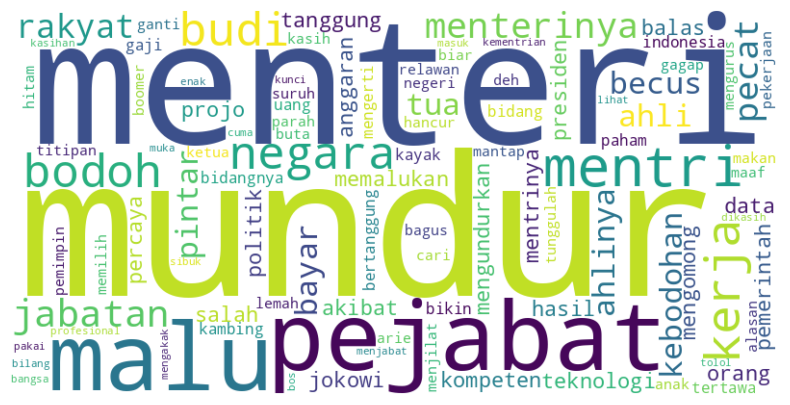

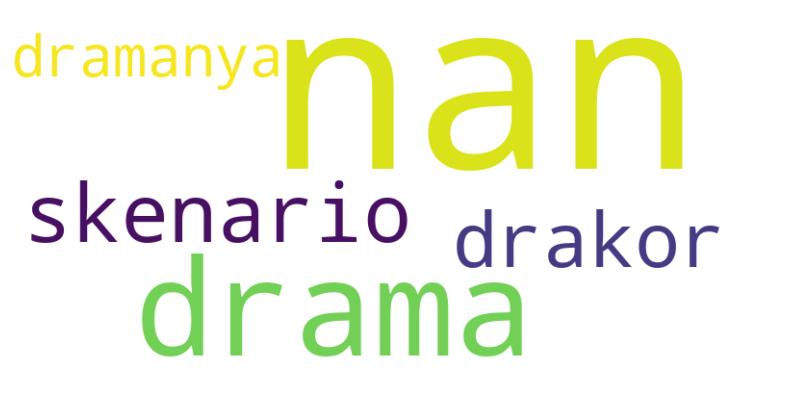

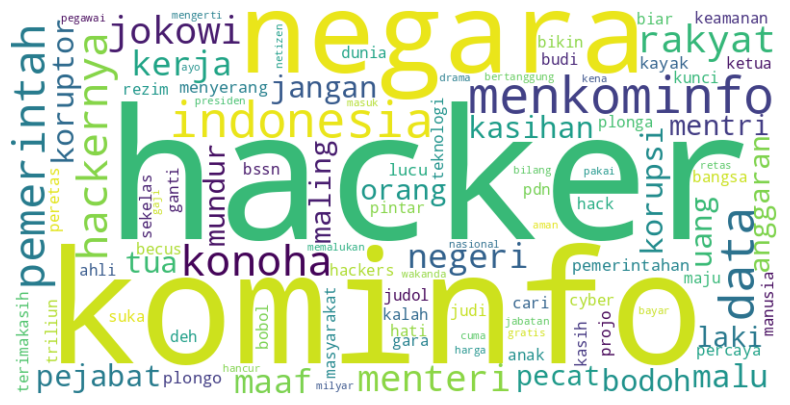

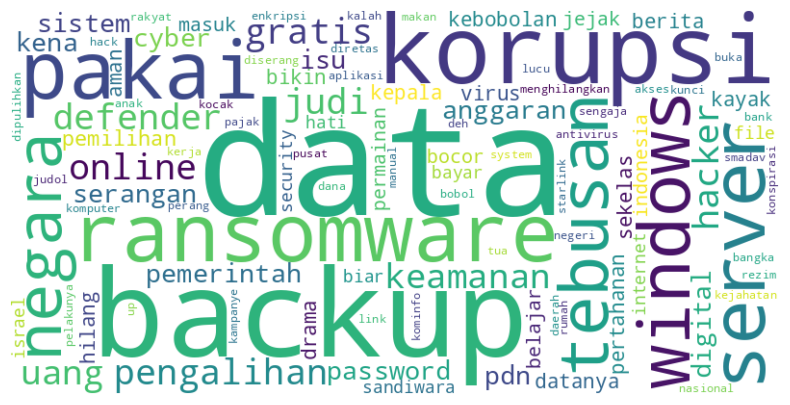

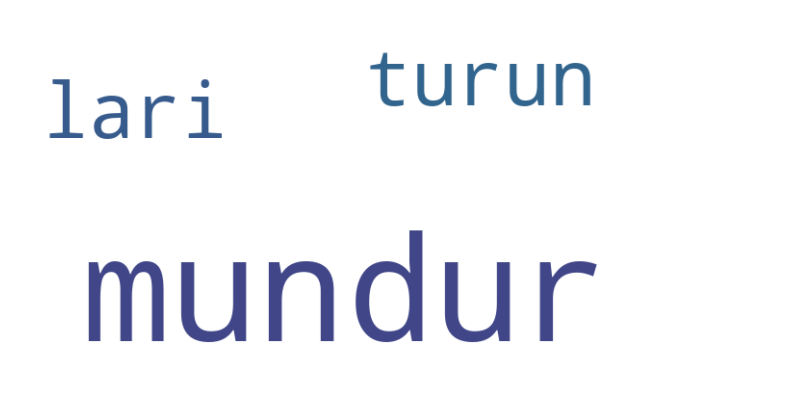

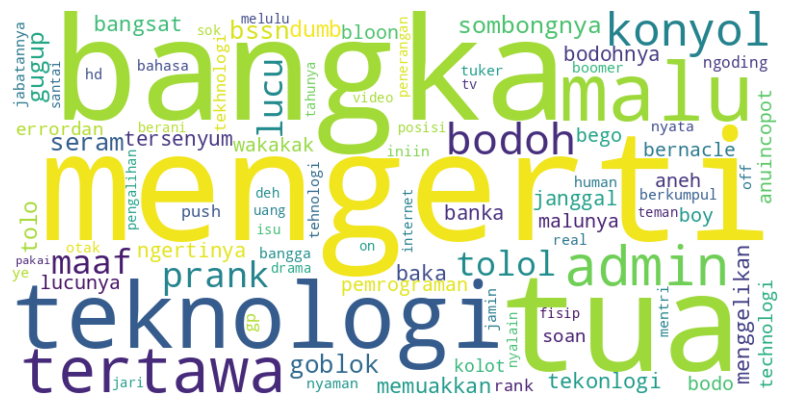

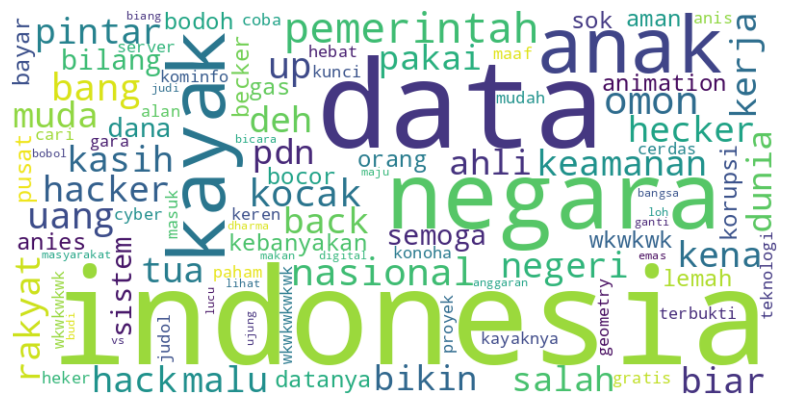

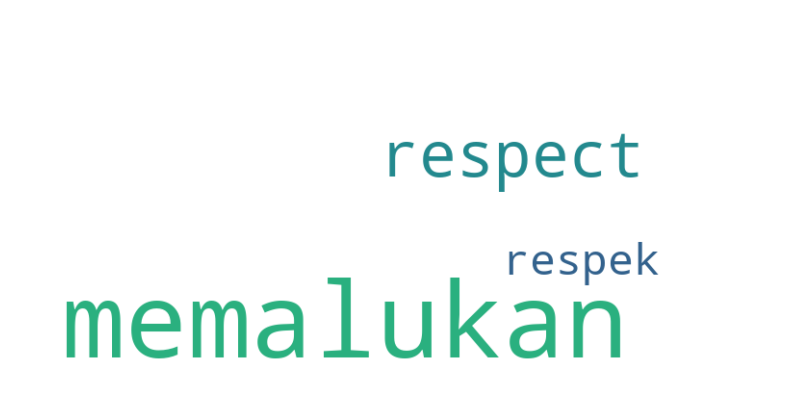

In [171]:
plot_word_cloud(topics)

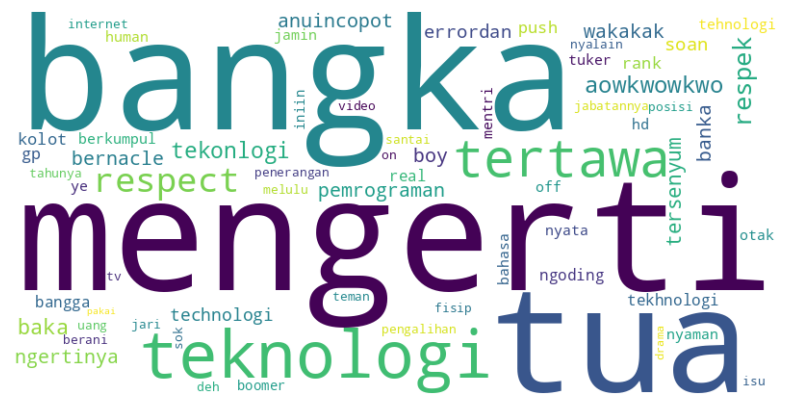

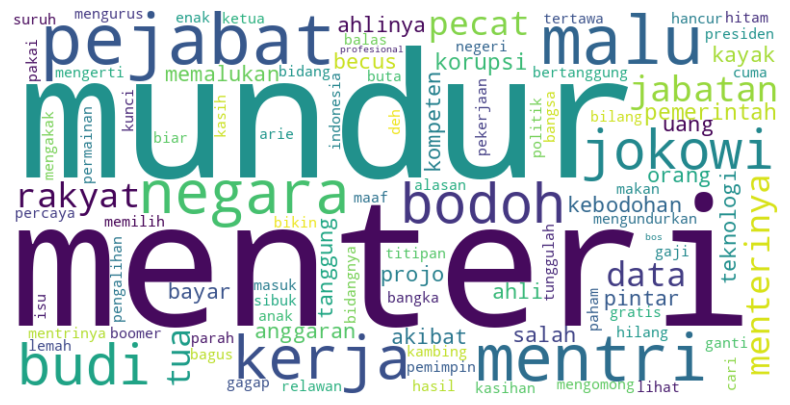

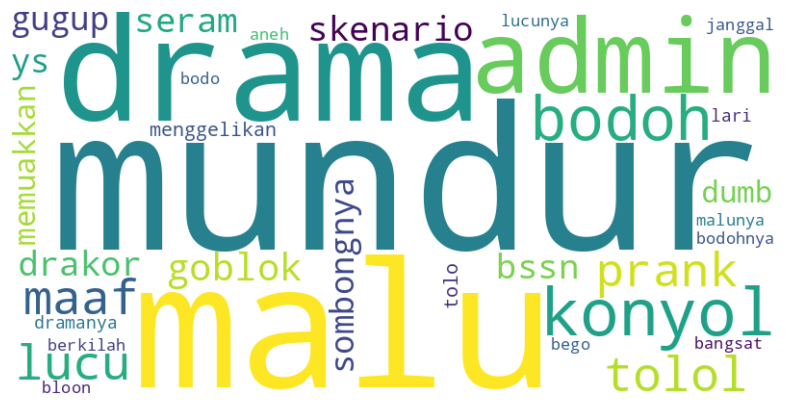

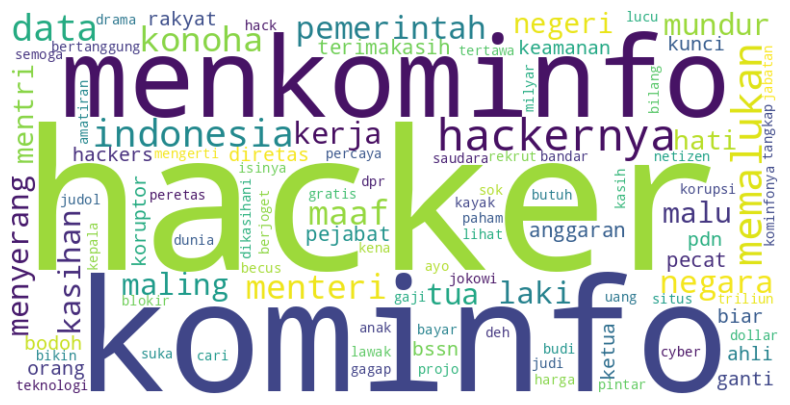

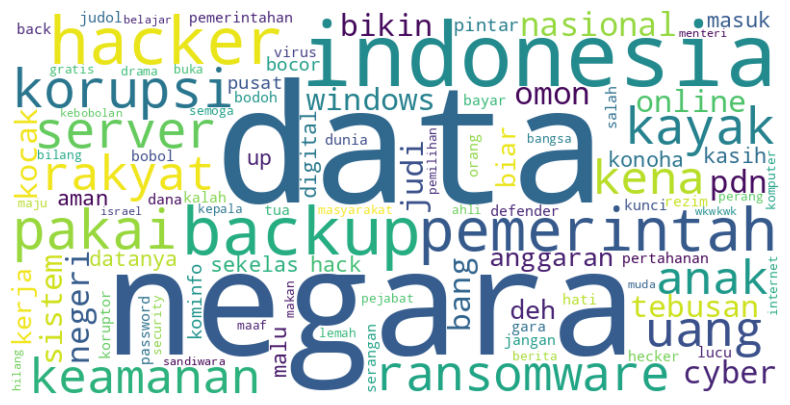

In [160]:
plot_word_cloud(topics)

## Old

In [73]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.coherencemodel import CoherenceModel
from collections import defaultdict

# Vectorize the UMAP embeddings
vectorizer = CountVectorizer()
X = vectorizer.fit_transform([" ".join(map(str, emb)) for emb in umap_embeddings])

# LDA and Coherence evaluation
coherence_scores = []
best_model = None
best_num_topics = 0
best_coherence_score = 0

for num_topics in range(2, 21):
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_model.fit(X)
    topic_term_distributions = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]

    # Prepare input for CoherenceModel from gensim
    top_words_per_topic = defaultdict(list)
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(topic_term_distributions):
        top_words_indices = topic.argsort()[-10:][::-1]
        top_words = [feature_names[i] for i in top_words_indices]
        top_words_per_topic[topic_idx] = top_words

    print(top_words_per_topic)
#     coherence_model = CoherenceModel(topics=list(top_words_per_topic.values()), texts=[text.split() for text in texts], coherence='c_v')
#     coherence_score = coherence_model.get_coherence()
#     coherence_scores.append((num_topics, coherence_score))
    
#     if coherence_score > best_coherence_score:
#         best_coherence_score = coherence_score
#         best_model = lda_model
#         best_num_topics = num_topics

# print(f"Best Coherence Score: {best_coherence_score} with {best_num_topics} topics")


defaultdict(<class 'list'>, {0: ['10', '11', '0436497', '83361', '612006', '7305427', '094087', '0619917', '143946', '7239532'], 1: ['10', '11', '1514506', '1748433', '552798', '1670256', '155431', '025173', '931751', '6953855']})
defaultdict(<class 'list'>, {0: ['10', '11', '83361', '094087', '612006', '8144684', '1025424', '06242', '152328', '0134196'], 1: ['10', '11', '1748433', '1514506', '1756372', '025173', '1670256', '0872483', '552798', '03624'], 2: ['10', '11', '6953855', '010956', '955177', '7873898', '8017755', '173975', '155431', '17022']})
defaultdict(<class 'list'>, {0: ['10', '11', '83361', '1651707', '094087', '201448', '325719', '147474', '8066297', '8065467'], 1: ['10', '11', '1670256', '552798', '186725', '793706', '5698876', '025173', '0872483', '7947793'], 2: ['10', '11', '7873898', '8017755', '143946', '0751004', '8679733', '1014767', '868236', '112076'], 3: ['10', '11', '6953855', '8521447', '047068', '211517', '3092666', '9996862', '626643', '133629']})
defaultd

In [32]:
# !pip install hdbscan

In [37]:
import hdbscan

# Jika ingin mengevaluasi berbagai parameter HDBSCAN
best_score = -1
best_params = None
scores = []

min_cluster_sizes = range(2, 21)
for min_cluster_size in min_cluster_sizes:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean')
    cluster_labels = clusterer.fit_predict(umap_embeddings)
    if len(set(cluster_labels)) > 1:
        silhouette_avg = silhouette_score(umap_embeddings, cluster_labels)
        scores.append((min_cluster_size, silhouette_avg))
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_params = min_cluster_size

print(f'Best Silhouette Score: {best_score} with min_cluster_size: {best_params}')

Best Silhouette Score: 0.573306143283844 with min_cluster_size: 9


In [40]:
df_silhouette = pd.DataFrame(scores, columns=['n_cluster', 'silhouette_indobert'])
df_silhouette.to_csv('silhouette.csv')

/home/abid/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/abid/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/abid/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/abid/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

Best Silhouette Score: 0.4544624388217926 with n_clusters: 2


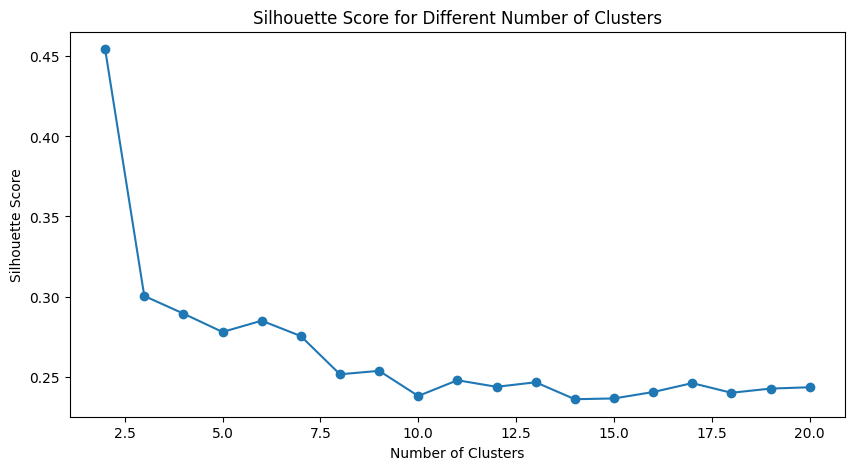

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Fungsi untuk menemukan jumlah cluster terbaik menggunakan Silhouette Score
def find_best_k(embeddings, max_k=20):
    best_score = -1
    best_k = 2
    scores = []
    
    for n_clusters in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)
        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        scores.append((n_clusters, silhouette_avg))
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_k = n_clusters
            
    return best_k, best_score, scores
# print(f'Best Silhouette Score: {best_score} with min_samples: {best_params[0]} and min_cluster_size: {best_params[1]}')
# Cari jumlah cluster terbaik
best_k, best_score, scores = find_best_k(umap_embeddings)

print(f'Best Silhouette Score: {best_score} with n_clusters: {best_k}')

# Convert scores to DataFrame for visualization
scores_df = pd.DataFrame(scores, columns=['n_clusters', 'silhouette_score'])

# Visualisasi silhouette score untuk setiap jumlah cluster
plt.figure(figsize=(10, 5))
plt.plot(scores_df['n_clusters'], scores_df['silhouette_score'], marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Number of Clusters')
plt.show()


In [42]:
import matplotlib.pyplot as plt
from collections import Counter
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

/home/abid/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [56]:
# # HDBSCAN clustering
# clusterer = hdbscan.HDBSCAN(min_cluster_size=9, metric='euclidean')
# cluster_labels = clusterer.fit_predict(umap_embeddings)
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Memisahkan teks berdasarkan cluster
clustered_texts = {}
for label, text in zip(cluster_labels, df['text_clean']):
    if label not in clustered_texts:
        clustered_texts[label] = []
    clustered_texts[label].append(text)

# Ekstrak topik dari setiap cluster dengan menghitung kata-kata yang paling sering muncul
def extract_top_words(texts, num_words=10):
    all_words = " ".join(texts).split()
    counter = Counter(all_words)
    return [word for word, _ in counter.most_common(num_words)]

top_words_per_cluster = {}
for label, texts in clustered_texts.items():
    if label != -1:  # ignore noise points
        top_words_per_cluster[label] = extract_top_words(texts)

# Menampilkan topik yang dihasilkan oleh clustering
for label, top_words in top_words_per_cluster.items():
    print(f"Cluster {label} top words: {top_words}")

/home/abid/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 1 top words: ['di', 'yg', 'dan', 'ini', 'yang', 'data', 'ada', 'itu', 'negara', 'bisa']
Cluster 0 top words: ['hacker', 'pak', 'ini', 'memalukan', 'kominfo', 'drama', 'malu', 'ada', 'mundur', 'apa']


In [61]:
top_words_per_cluster

{1: ['di', 'yg', 'dan', 'ini', 'yang', 'data', 'ada', 'itu', 'negara', 'bisa'],
 0: ['hacker',
  'pak',
  'ini',
  'memalukan',
  'kominfo',
  'drama',
  'malu',
  'ada',
  'mundur',
  'apa']}

In [64]:
from gensim.models.coherencemodel import CoherenceModel

# Example top_words_per_cluster:
top_words_per_cluster = {
    0: ['word1', 'word2', 'word3'],
    1: ['word4', 'word5', 'word6']
}

# Example texts per cluster:
clustered_texts = {
    0: ['text1 cluster 0', 'text2 cluster 0'],
    1: ['text1 cluster 1', 'text2 cluster 1']
}

# Flatten texts for each cluster
texts_per_cluster = [' '.join(texts) for cluster, texts in clustered_texts.items()]

# Example coherence score calculation
coherence_values = []
for cluster_id, top_words in top_words_per_cluster.items():
    coherence_model = CoherenceModel(topics=[top_words], texts=texts_per_cluster[cluster_id], dictionary=None, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_values.append(coherence_score)
    print(f"Cluster {cluster_id} coherence score: {coherence_score}")


ValueError: dictionary has to be provided if topics are to be used.